# Import libraries

In [127]:
import mlrose_hiive
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm
import matplotlib.pyplot as plt

from mlrose_hiive import ExpDecay, OneMax, TSPOpt, DiscreteOpt
from mlrose_hiive import RHCRunner, SARunner, GARunner, MIMICRunner
from mlrose_hiive import TravellingSales, FourPeaks, Queens

# Hyperparameter Tuning

In [28]:
opt_probs = ["Queens"]  #["FourPeaks", "TravellingSales", "Queens"] 

for opt_prob in opt_probs:
    print(f"Finding best RHC hyper parameters for {opt_prob}")
    number_of_nodes = 16
    
    # Determine length of state vector based on problem
    if opt_prob == "TravellingSales":
        dist_list = generate_tsp_instance(number_of_nodes)
        fitness_dists = TravellingSales(distances = dist_list)
        problem = mlrose_hiive.TSPOpt(length=number_of_nodes, fitness_fn=fitness_dists)

    elif opt_prob == "FourPeaks":
        objective = mlrose_hiive.FourPeaks()
        problem = mlrose_hiive.DiscreteOpt(length=100, fitness_fn=objective, maximize=True, max_val=2)

    elif opt_prob == "Queens":
        objective = mlrose_hiive.Queens()
        problem = mlrose_hiive.DiscreteOpt(length=number_of_nodes, fitness_fn=objective, maximize=False, max_val = number_of_nodes)

    best_restart_param = None
    best_restart_fitness_value = None
    
    for i in tqdm([80, 160, 320]):
        results = mlrose_hiive.random_hill_climb(problem, max_attempts = 500, max_iters=2048, curve=True, random_state=42, restarts = i)
        rhc_best_state, rhc_best_fitness, rhc_fitness_curve = results
        
        if not best_restart_fitness_value or rhc_best_fitness < best_restart_fitness_value:
            best_restart_param = i
            best_restart_fitness_value = rhc_best_fitness
            
    print(f"Best RHC hyper parameters for {opt_prob}:\n\t restarts: {best_restart_param}\n")

Finding best RHC hyper parameters for Queens


100%|███████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:16<00:00, 45.58s/it]

Best RHC hyper parameters for Queens:
	 restarts: 320



In [46]:
# SA Tuning

# init_temp, decay, min_temp
sa_hyperparams = [
   [1, 64, 512, 2048],
   [0.001, 0.01, 0.05, 0.1, 0.2],
   [0.001, 0.01, 0.1, 0.5], #[0.1, 1, 2, 4, 8]
]


for opt_prob in opt_probs:
    print(f"Finding best SA hyper parameters for {opt_prob}")
    number_of_nodes = 16
    
    
    # Determine length of state vector based on problem
    if opt_prob == "TravellingSales":
        dist_list = generate_tsp_instance(number_of_nodes)
        fitness_dists = TravellingSales(distances = dist_list)
        problem = mlrose_hiive.TSPOpt(length=number_of_nodes, fitness_fn=fitness_dists)

    elif opt_prob == "FourPeaks":
        objective = mlrose_hiive.FourPeaks()
        problem = mlrose_hiive.DiscreteOpt(length=100, fitness_fn=objective, maximize=True, max_val=2)

    elif opt_prob == "Queens":
        objective = mlrose_hiive.Queens()
        problem = mlrose_hiive.DiscreteOpt(length=number_of_nodes, fitness_fn=objective, maximize=False, max_val = number_of_nodes)
    
    best_sa_param = None
    best_sa_fitness_value = None
    
    for i in tqdm(list(itertools.product(*sa_hyperparams))):
        
        decay = mlrose_hiive.ExpDecay(init_temp = i[0], exp_const=i[1], min_temp=i[2])
        
        results = mlrose_hiive.simulated_annealing(problem, max_attempts=100, max_iters=2048, curve=True, random_state=42, schedule=decay)
        sa_best_state, sa_best_fitness, sa_fitness_curve = results
        
        if not best_sa_fitness_value or sa_best_fitness > best_sa_fitness_value:
            best_sa_param = i
            best_sa_fitness_value = sa_best_fitness
            
    init_temp, exp_const, min_temp = best_sa_param
    print(f"Best SA hyper parameters for {opt_prob}:\n\tinit_temp: {init_temp}\n\texp_const: {exp_const}\n\tmin_temp: {min_temp}\n")

Finding best SA hyper parameters for FourPeaks


100%|█████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:04<00:00, 18.24it/s]

Best SA hyper parameters for FourPeaks:
	init_temp: 1
	exp_const: 0.05
	min_temp: 0.001



In [38]:
# GA Tuning

# pop_size, mutation_prob
ga_hyperparams = [
   [200, 400, 800, 1600, 3200],
   [0.01, 0.1, 0.2, 0.4, 0.8]
]


for opt_prob in opt_probs:
    best_ga_param = None
    best_ga_fitness_value = None
    
    print(f"Finding best GA hyper parameters for {opt_prob}")
    number_of_nodes = 16
    
    
    # Determine length of state vector based on problem
    if opt_prob == "TravellingSales":
        dist_list = generate_tsp_instance(number_of_nodes)
        fitness_dists = TravellingSales(distances = dist_list)
        problem = mlrose_hiive.TSPOpt(length=number_of_nodes, fitness_fn=fitness_dists)

    elif opt_prob == "FourPeaks":
        objective = mlrose_hiive.FourPeaks()
        problem = mlrose_hiive.DiscreteOpt(length=100, fitness_fn=objective, maximize=True, max_val=2)

    elif opt_prob == "Queens":
        objective = mlrose_hiive.Queens()
        problem = mlrose_hiive.DiscreteOpt(length=number_of_nodes, fitness_fn=objective, maximize=False, max_val = number_of_nodes)
        
    for i in tqdm(list(itertools.product(*ga_hyperparams))):
        results = mlrose_hiive.genetic_alg(problem, max_attempts=500, max_iters=2048, curve=True, random_state=42,pop_size=i[0],mutation_prob=i[1])
        ga_best_state, ga_best_fitness, ga_fitness_curve = results
        
        if not best_ga_fitness_value or ga_best_fitness < best_ga_fitness_value:
            best_ga_param = i
            best_ga_fitness_value = ga_best_fitness
    pop_size, mutation_prob = best_ga_param
    print(f"Best GA hyper parameters for {opt_prob}:\n\tpop_size: {pop_size}\n\tmutation_prob: {mutation_prob}\n")

Finding best GA hyper parameters for Queens


100%|██████████████████████████████████████████████████████████████████████████████████████| 25/25 [3:07:33<00:00, 450.14s/it]

Best GA hyper parameters for Queens:
	pop_size: 3200
	mutation_prob: 0.8



In [37]:
# MIMIC Tuning

mimic_hyperparams = [
   [800, 1600, 3200, 6400],
   [0.01, 0.05, 0.1]
]
for opt_prob in opt_probs:
    best_mimic_param = None
    best_mimic_fitness_value = None
    
    print(f"Finding best MIMIC hyper parameters for {opt_prob}")
    number_of_nodes = 16
    
    
    # Determine length of state vector based on problem
    if opt_prob == "TravellingSales":
        dist_list = generate_tsp_instance(number_of_nodes)
        fitness_dists = TravellingSales(distances = dist_list)
        problem = mlrose_hiive.TSPOpt(length=number_of_nodes, fitness_fn=fitness_dists)

    elif opt_prob == "FourPeaks":
        objective = mlrose_hiive.FourPeaks()
        problem = mlrose_hiive.DiscreteOpt(length=100, fitness_fn=objective, maximize=True, max_val=2)

    elif opt_prob == "Queens":
        objective = mlrose_hiive.Queens()
        problem = mlrose_hiive.DiscreteOpt(length=number_of_nodes, fitness_fn=objective, maximize=False, max_val = number_of_nodes)

    for i in tqdm(list(itertools.product(*mimic_hyperparams))):
        results = mlrose_hiive.mimic(problem, max_attempts = 100, max_iters = 2048,  curve = True, random_state = 42, pop_size=i[0], keep_pct=i[1])
        mimic_best_state, mimic_best_fitness, mimic_fitness_curve = results
        
        if not best_mimic_fitness_value or mimic_best_fitness < best_mimic_fitness_value:
            best_mimic_param = i
            best_mimic_fitness_value = mimic_best_fitness
    mimic_pop_size, keep_pct = best_mimic_param
    print(f"Best MIMIC hyper parameters for {opt_prob}:\n\tpop_size: {mimic_pop_size}\n\keep_pct: {keep_pct}\n")

Finding best MIMIC hyper parameters for Queens


100%|████████████████████████████████████████████████████████████████████████████████████████| 12/12 [21:36<00:00, 108.01s/it]

Best MIMIC hyper parameters for Queens:
	pop_size: 1600
\keep_pct: 0.05



# Four Peaks Model Training

In [132]:
sizes = [1028] #[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1028]
seeds = [888]
sizes_seeds = [sizes, seeds]
# Create an empty DataFrame to store the results
columns = ['Algorithm', 'Problem_Size', 'Seed', 'Iteration', 'Fitness', 'Time', 'FEvals']
df_results_four_peaks = pd.DataFrame(columns=columns)

# Run optimization algorithms for each problem size and seed
for size_seed in tqdm(list(itertools.product(*sizes_seeds))):
        size = size_seed[0]
        seed = size_seed[1]
        # Define the fitness function
        objective = mlrose_hiive.FourPeaks()

        # Define the problem using DiscreteOpt
        four_peaks_problem = mlrose_hiive.DiscreteOpt(length=size, fitness_fn=objective, maximize=True, max_val=2)

        # Define optimization algorithms
        four_peaks_algorithms = {
            # 'RHC': RHCRunner(problem=four_peaks_problem, experiment_name=f'four_peaks_rhc_{size}_{seed}', seed=seed, max_attempts=20, iteration_list=[512], restart_list=[175]),
            # 'SA': SARunner(problem=four_peaks_problem, experiment_name=f'four_peaks_sa_{size}_{seed}', seed=seed, iteration_list=[512], temperature_list=[ExpDecay(init_temp=1, exp_const=0.1, min_temp=0.001)]),
            # 'GA': GARunner(problem=four_peaks_problem, experiment_name=f'four_peaks_ga_{size}_{seed}', seed=seed,  iteration_list=[512], population_sizes=[100], mutation_rates=[0.5]),
            'MIMIC': MIMICRunner(problem=four_peaks_problem, experiment_name=f'four_peaks_mimic_{size}_{seed}', seed=seed, use_fast_mimic=True, max_attempts=512, iteration_list=[512], population_sizes=[800], keep_percent_list=[0.2])
        }

        # Run optimization algorithms for current problem size and seed
        for name, algorithm in four_peaks_algorithms.items():
            results = algorithm.run()

            # Extract fitness curve data
            fitness_curve = results[1]

            # Create a DataFrame for the current algorithm, problem size, and seed
            df_temp = pd.DataFrame(fitness_curve, columns=['Iteration', 'Fitness', 'Time', 'FEvals'])

            # Add algorithm, problem size, and seed to the DataFrame
            df_temp['Algorithm'] = name
            df_temp['Problem_Size'] = size
            df_temp['Seed'] = seed

            # Append the DataFrame to the results DataFrame
            df_results_four_peaks = pd.concat([df_results_four_peaks, df_temp], ignore_index=True)

# Compute the average fitness for each algorithm, problem size, and seed
average_four_peaks_results = df_results_four_peaks.groupby(['Algorithm', 'Problem_Size', 'Iteration']).mean().reset_index()

100%|███████████████████████████████████████| 15/15 [3:42:45<00:00, 891.02s/it]


In [135]:
df_results_four_peaks.to_csv("df_results_four_peaks.csv", index = None)

# Four Peaks Plotting

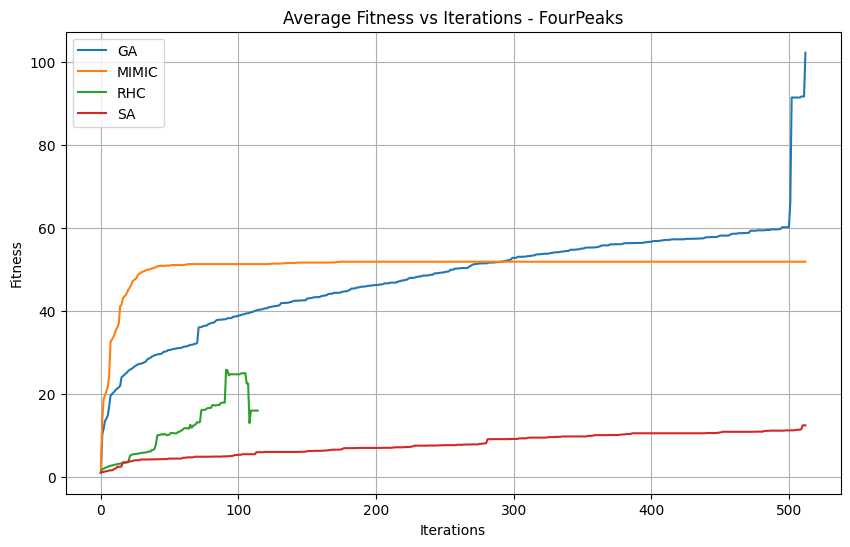

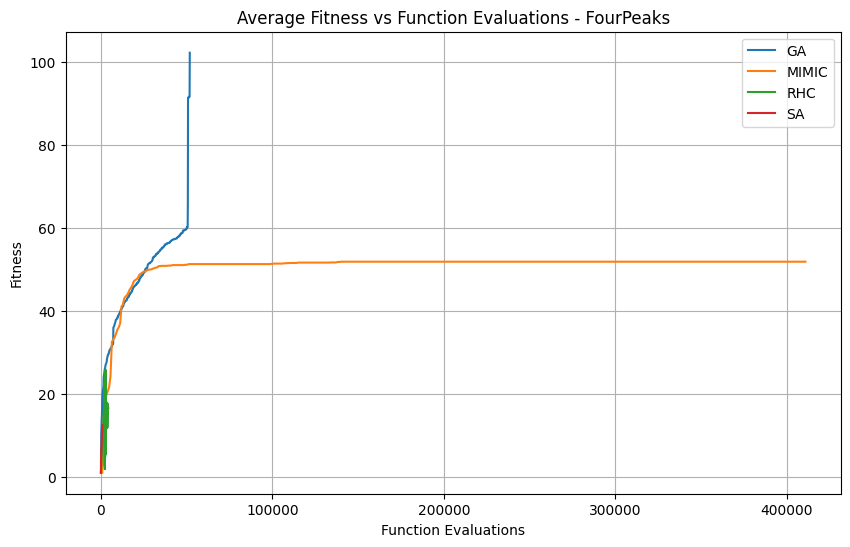

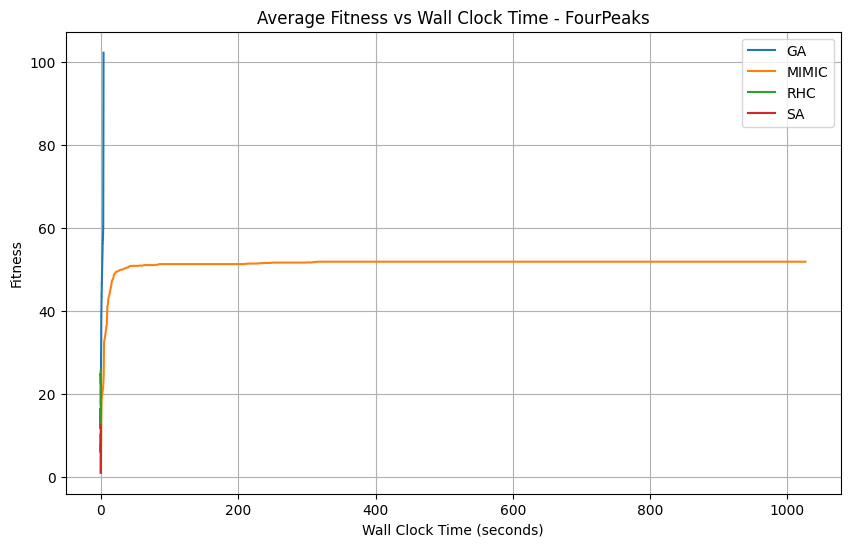

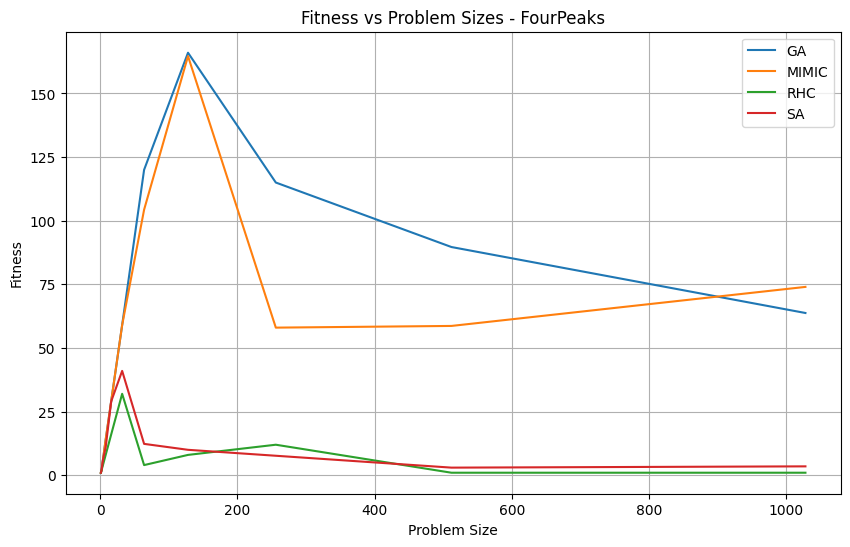

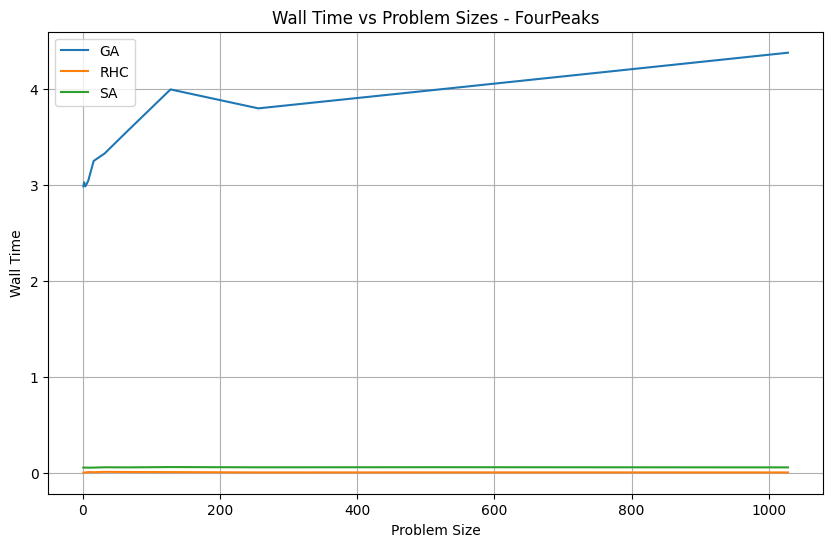

In [63]:
# Compute the average fitness across problem sizes for each algorithm and iteration
average_fitness_per_algorithm = average_four_peaks_results.groupby(['Algorithm', 'Iteration'])['Fitness'].mean().reset_index()
# Compute the average function evaluations and time across problem sizes for each algorithm and iteration
average_fevals_per_algorithm = average_four_peaks_results.groupby(['Algorithm', 'Iteration'])['FEvals'].mean().reset_index()
average_time_per_algorithm = average_four_peaks_results.groupby(['Algorithm', 'Iteration'])['Time'].mean().reset_index()

# Since we want to plot Fitness vs FEvals and Fitness vs Time, we merge the average_fitness with average_fevals and average_time
average_fitness_fevals = pd.merge(average_fitness_per_algorithm, average_fevals_per_algorithm, on=['Algorithm', 'Iteration'])
average_fitness_time = pd.merge(average_fitness_per_algorithm, average_time_per_algorithm, on=['Algorithm', 'Iteration'])

# Plot 1: Fitness vs. Iterations (Epochs)
plt.figure(figsize=(10, 6))
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.title('Average Fitness vs Iterations - FourPeaks')
for algorithm in average_fitness_per_algorithm['Algorithm'].unique():
    subset = average_fitness_per_algorithm[average_fitness_per_algorithm['Algorithm'] == algorithm]
    plt.plot(subset['Iteration'], subset['Fitness'], label=f"{algorithm}")
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Average Fitness vs. Function Evaluations
plt.figure(figsize=(10, 6))
plt.xlabel('Function Evaluations')
plt.ylabel('Fitness')
plt.title('Average Fitness vs Function Evaluations - FourPeaks')
for algorithm in average_fitness_fevals['Algorithm'].unique():
    subset = average_fitness_fevals[average_fitness_fevals['Algorithm'] == algorithm].sort_values(by='FEvals')
    plt.plot(subset['FEvals'], subset['Fitness'], label=f"{algorithm}")
plt.legend()
plt.grid(True)
plt.show()

# Plot 3: Average Fitness vs. Wall Clock Time
plt.figure(figsize=(10, 6))
plt.xlabel('Wall Clock Time (seconds)')
plt.ylabel('Fitness')
plt.title('Average Fitness vs Wall Clock Time - FourPeaks')
for algorithm in average_fitness_time['Algorithm'].unique():
    subset = average_fitness_time[average_fitness_time.Algorithm == algorithm].sort_values(by='Time')
    plt.plot(subset['Time'], subset['Fitness'], label=f"{algorithm}")
plt.legend()
plt.grid(True)
plt.show()

# Plot 4: Fitness vs. Problem Size
plt.figure(figsize=(10, 6))
problem_sizes = sorted(set(average_four_peaks_results['Problem_Size']))
algorithms = sorted(set(average_four_peaks_results['Algorithm']))

for algorithm in algorithms:
    fitness_values = []
    for problem_size in problem_sizes:
        subset = average_four_peaks_results[(average_four_peaks_results['Algorithm'] == algorithm) & (average_four_peaks_results['Problem_Size'] == problem_size)]
        fitness_values.append(subset['Fitness'].iloc[-1])
    plt.plot(problem_sizes, fitness_values, label=algorithm)

plt.xlabel('Problem Size')
plt.ylabel('Fitness')
plt.title('Fitness vs Problem Sizes - FourPeaks')
plt.legend()
plt.grid(True)
plt.show()

# Plot 5: Wall Time vs. Problem Size
plt.figure(figsize=(10, 6))
problem_sizes = sorted(set(average_four_peaks_results['Problem_Size']))
algorithms = sorted(set(average_four_peaks_results['Algorithm']))

for algorithm in algorithms:
    fitness_values = []
    if algorithm != 'MIMIC':
        for problem_size in problem_sizes:
            subset = average_four_peaks_results[(average_four_peaks_results['Algorithm'] == algorithm) & (average_four_peaks_results['Problem_Size'] == problem_size)]
            fitness_values.append(subset['Time'].iloc[-1])
        plt.plot(problem_sizes, fitness_values, label=algorithm)

plt.xlabel('Problem Size')
plt.ylabel('Wall Time')
plt.title('Wall Time vs Problem Sizes - FourPeaks')
plt.legend()
plt.grid(True)
plt.show()

# Queens Model Training

In [89]:
sizes = [4, 8, 16, 32, 64]
seeds = [8, 88, 888]
sizes_seeds = [sizes, seeds]
# Create an empty DataFrame to store the results
columns = ['Algorithm', 'Problem_Size', 'Seed', 'Iteration', 'Fitness', 'Time', 'FEvals']
df_results_queens = pd.DataFrame(columns=columns)

# Run optimization algorithms for each problem size and seed
for size_seed in tqdm(list(itertools.product(*sizes_seeds))):
        size = size_seed[0]
        seed = size_seed[1]
        # Define the fitness function
        objective = mlrose_hiive.Queens()

        # Define the problem using DiscreteOpt
        queens_problem = mlrose_hiive.DiscreteOpt(length=size, fitness_fn=objective, maximize=False, max_val = size)

        # Define optimization algorithms
        queens_algorithms = {
            'RHC': RHCRunner(problem=queens_problem, experiment_name=f'queens_rhc_{size}_{seed}', max_attempts=20, seed=seed, iteration_list=[1028], restart_list=[256]),
            'SA': SARunner(problem=queens_problem, experiment_name=f'queens_sa_{size}_{seed}', seed=seed, iteration_list=[1028], temperature_list=[ExpDecay(init_temp=2048, exp_const=0.1, min_temp=0.001)]),
            'GA': GARunner(problem=queens_problem, experiment_name=f'queens_ga_{size}_{seed}', seed=seed,  iteration_list=[1028], population_sizes=[320], mutation_rates=[0.8]),
            'MIMIC': MIMICRunner(problem=queens_problem, experiment_name=f'queens_mimic_{size}_{seed}', seed=seed, use_fast_mimic=True, max_attempts=1028, iteration_list=[1028], population_sizes=[320], keep_percent_list=[0.05])
        }

        # Run optimization algorithms for current problem size and seed
        for name, algorithm in queens_algorithms.items():
            results = algorithm.run()

            # Extract fitness curve data
            fitness_curve = results[1]

            # Create a DataFrame for the current algorithm, problem size, and seed
            df_temp = pd.DataFrame(fitness_curve, columns=['Iteration', 'Fitness', 'Time', 'FEvals'])

            # Add algorithm, problem size, and seed to the DataFrame
            df_temp['Algorithm'] = name
            df_temp['Problem_Size'] = size
            df_temp['Seed'] = seed

            # Append the DataFrame to the results DataFrame
            df_results_queens = pd.concat([df_results_queens, df_temp], ignore_index=True)

# Compute the average fitness for each algorithm, problem size, and seed
average_queens_results = df_results_queens.groupby(['Algorithm', 'Problem_Size', 'Iteration']).mean().reset_index()

100%|█████████████████████████████████████████| 5/5 [4:50:28<00:00, 3485.75s/it]


In [129]:
df_results_queens.to_csv("df_results_queens.csv", index = None)

# Queens Plotting

In [104]:
example_df = df_results_queens[df_results_queens.Fitness == 0].groupby(['Algorithm', 'Problem_Size', 'Seed'])['Iteration'].min().reset_index()

In [106]:
example_df = example_df.groupby(['Algorithm', 'Problem_Size'])['Iteration'].mean().reset_index()

In [107]:
example_df = example_df[example_df.Algorithm != 'MIMIC']

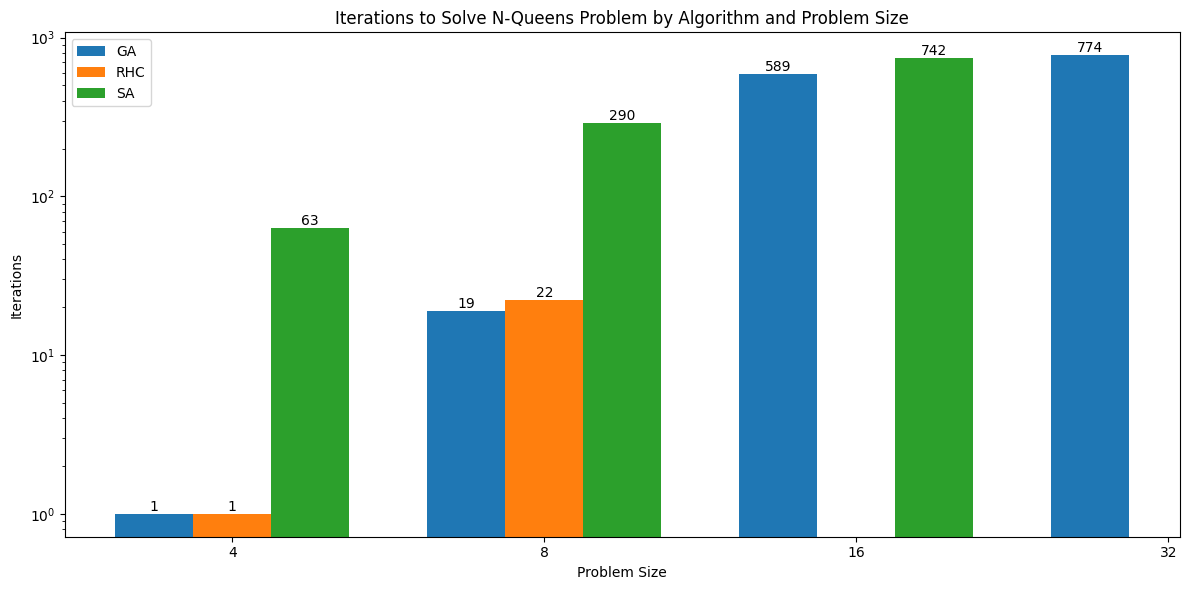

In [108]:
# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Get unique algorithms and problem sizes
algorithms = example_df['Algorithm'].unique()
problem_sizes = sorted(example_df['Problem_Size'].unique())

# Set width of bars and positions
bar_width = 0.25
r = np.arange(len(problem_sizes))

# Create bars for each algorithm
for i, alg in enumerate(algorithms):
    data = example_df[example_df['Algorithm'] == alg]
    iterations = [data[data['Problem_Size'] == size]['Iteration'].values[0] 
                  if size in data['Problem_Size'].values else np.nan 
                  for size in problem_sizes]
    position = [x + i*bar_width for x in r]
    bars = ax.bar(position, iterations, width=bar_width, label=alg)
    
    # Add value labels on the bars
    for bar in bars:
        height = bar.get_height()
        if not np.isnan(height):
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.0f}', ha='center', va='bottom')

# Customize the plot
ax.set_xlabel('Problem Size')
ax.set_ylabel('Iterations')
ax.set_title('Iterations to Solve N-Queens Problem by Algorithm and Problem Size')
ax.set_xticks([r + bar_width for r in range(len(problem_sizes))])
ax.set_xticklabels(problem_sizes)
ax.legend()

# Use logarithmic scale for y-axis due to large differences in values
ax.set_yscale('log')

# Show the plot
plt.tight_layout()
plt.show()

In [95]:
average_fevals_per_algorithm[average_fevals_per_algorithm.Algorithm == 'SA']

,Algorithm,Iteration,FEvals
1289,SA,0,0.000000
1290,SA,1,2.000000
1291,SA,2,4.000000
1292,SA,3,6.000000
1293,SA,4,8.000000
...,...,...,...
2313,SA,1024,1202.555556
2314,SA,1025,1203.555556
2315,SA,1026,1204.555556
2316,SA,1027,1205.555556


In [109]:
average_queens_results

,Algorithm,Problem_Size,Iteration,Seed,Fitness,Time,FEvals
0,GA,4,0,328.0,2.00,0.197722,1600.0
1,GA,4,1,328.0,0.00,0.486187,3202.0
2,GA,4,2,328.0,0.00,0.767541,4803.0
3,GA,4,3,328.0,0.00,1.050170,6404.0
4,GA,4,4,328.0,0.00,1.331827,8005.0
...,...,...,...,...,...,...,...
14335,SA,64,1024,248.0,12.25,1.950638,1247.0
14336,SA,64,1025,248.0,12.25,1.952372,1248.0
14337,SA,64,1026,248.0,12.25,1.954131,1249.0
14338,SA,64,1027,248.0,12.25,1.955870,1250.0


In [114]:
average_queens_results_fit_2 = average_queens_results.copy()

In [115]:
average_queens_results_fit_2['Fitness'] =  average_queens_results['Fitness']/average_queens_results['Problem_Size']

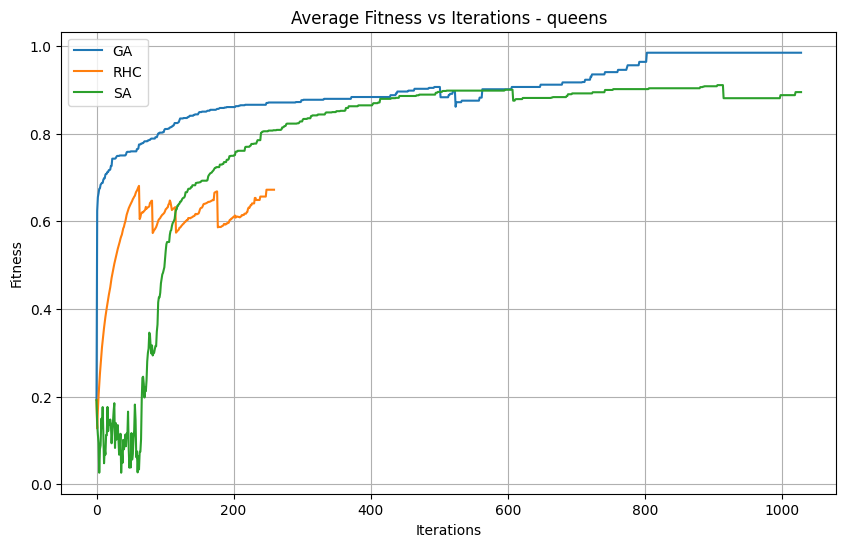

In [117]:
# Compute the average fitness across problem sizes for each algorithm and iteration
average_fitness_per_algorithm = average_queens_results_fit_2.groupby(['Algorithm', 'Iteration'])['Fitness'].mean().reset_index()
# Compute the average function evaluations and time across problem sizes for each algorithm and iteration
average_fevals_per_algorithm = average_queens_results.groupby(['Algorithm', 'Iteration'])['FEvals'].mean().reset_index()
average_time_per_algorithm = average_queens_results.groupby(['Algorithm', 'Iteration'])['Time'].mean().reset_index()

# Since we want to plot Fitness vs FEvals and Fitness vs Time, we merge the average_fitness with average_fevals and average_time
average_fitness_fevals = pd.merge(average_fitness_per_algorithm, average_fevals_per_algorithm, on=['Algorithm', 'Iteration'])
average_fitness_time = pd.merge(average_fitness_per_algorithm, average_time_per_algorithm, on=['Algorithm', 'Iteration'])

# Plot 1: Fitness vs. Iterations (Epochs) - This one is correct as per your initial code
plt.figure(figsize=(10, 6))
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.title('Average Fitness vs Iterations - queens')
for algorithm in average_fitness_per_algorithm['Algorithm'].unique():
    subset = average_fitness_per_algorithm[average_fitness_per_algorithm['Algorithm'] == algorithm]
    plt.plot(subset['Iteration'], 1-subset['Fitness'], label=f"{algorithm}")
plt.legend()
plt.grid(True)
plt.show()

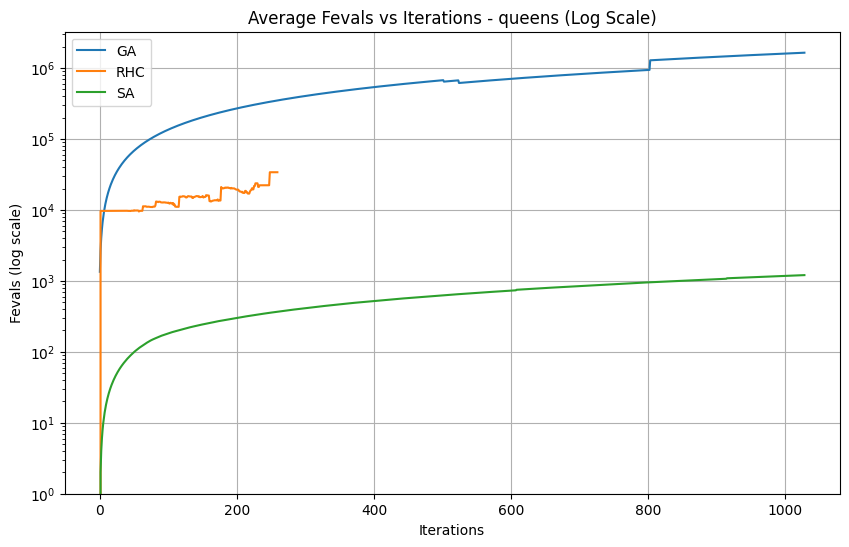

In [121]:
plt.figure(figsize=(10, 6))
plt.xlabel('Iterations')
plt.ylabel('Fevals (log scale)')
plt.title('Average Fevals vs Iterations - queens (Log Scale)')

for algorithm in average_fevals_per_algorithm['Algorithm'].unique():
    subset = average_fevals_per_algorithm[average_fevals_per_algorithm['Algorithm'] == algorithm]
    plt.plot(subset['Iteration'], subset['FEvals'], label=f"{algorithm}")

plt.legend()
plt.grid(True)
plt.yscale('log')  # This line applies the logarithmic scale to the y-axis
plt.ylim(bottom=1)  # This ensures the log scale starts at 1, not 0
plt.show()

In [126]:
average_time_per_algorithm[average_time_per_algorithm.Iteration ==1028]

,Algorithm,Iteration,Time
1028,GA,1028,947.246514
2317,SA,1028,1.234983


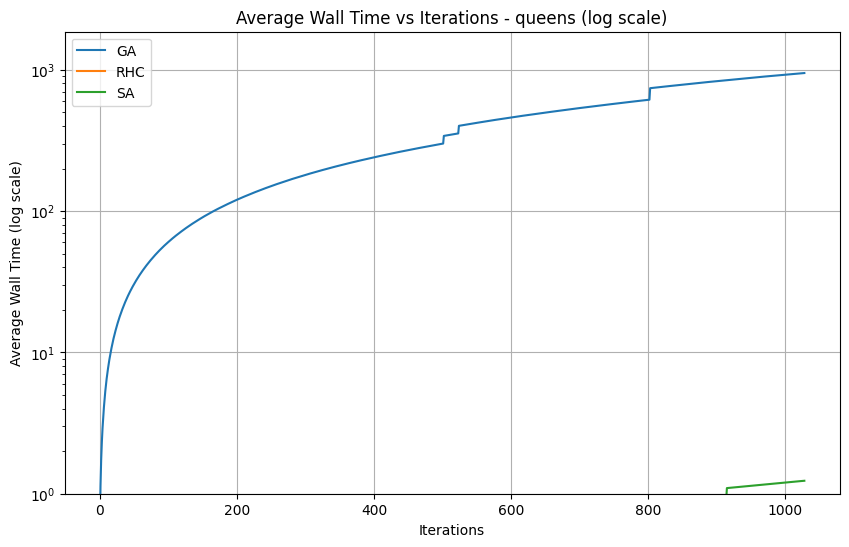

In [124]:
plt.figure(figsize=(10, 6))
plt.xlabel('Iterations')
plt.ylabel('Average Wall Time (log scale)')
plt.title('Average Wall Time vs Iterations - queens (log scale)')

for algorithm in average_time_per_algorithm['Algorithm'].unique():
    subset = average_time_per_algorithm[average_time_per_algorithm['Algorithm'] == algorithm]
    plt.plot(subset['Iteration'], subset['Time'], label=f"{algorithm}")

plt.legend()
plt.grid(True)
plt.yscale('log')  # This line applies the logarithmic scale to the y-axis
plt.ylim(bottom=1)  # This ensures the log scale starts at 1, not 0
plt.show()

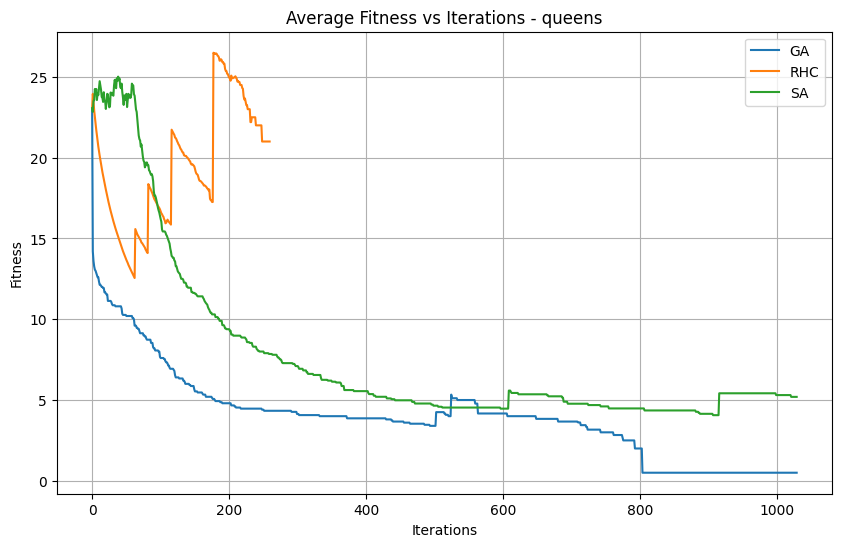

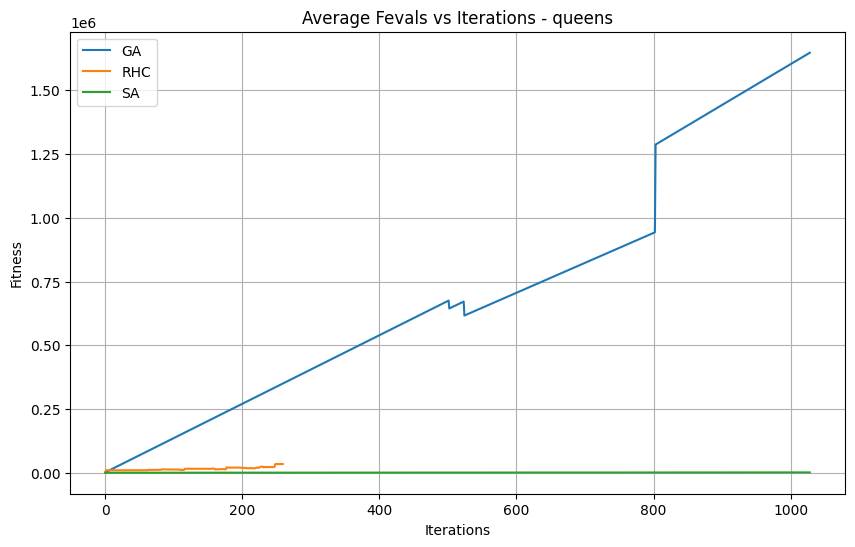

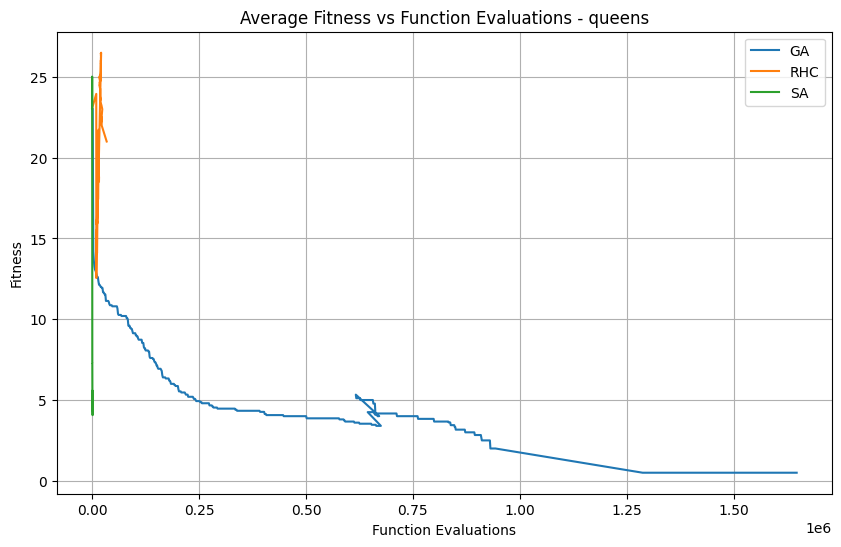

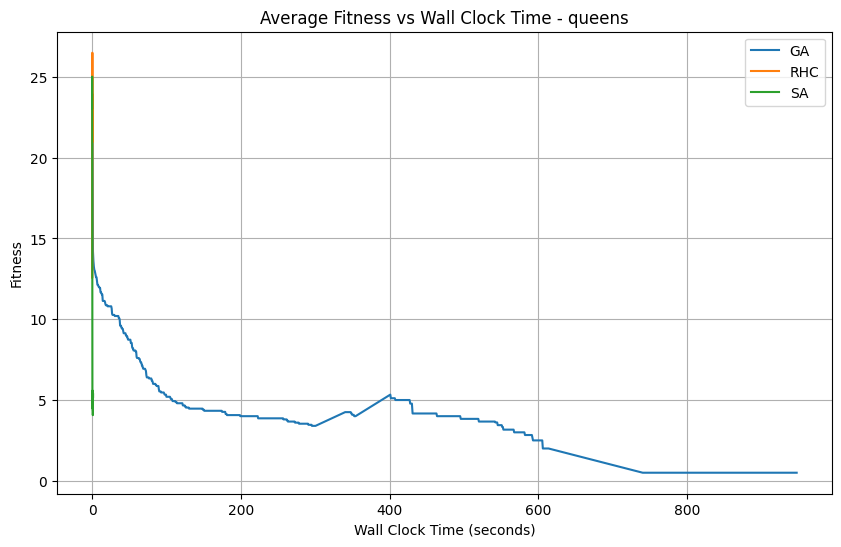

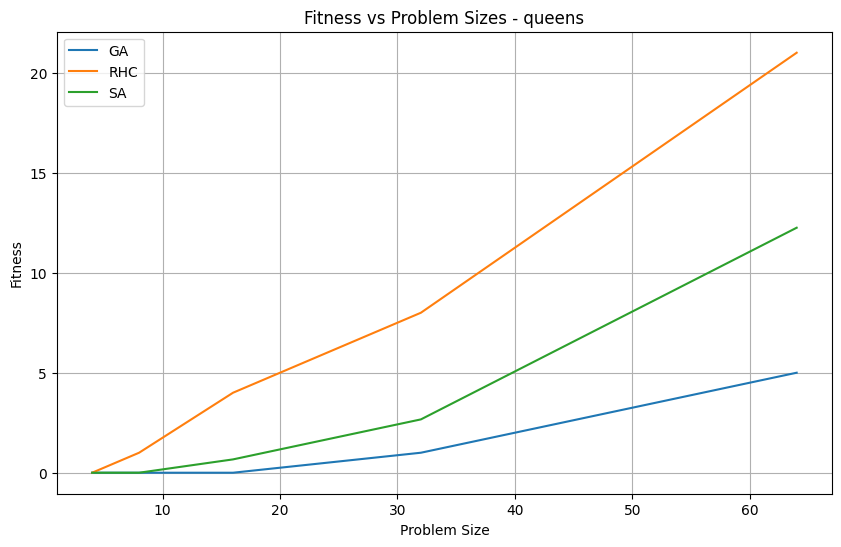

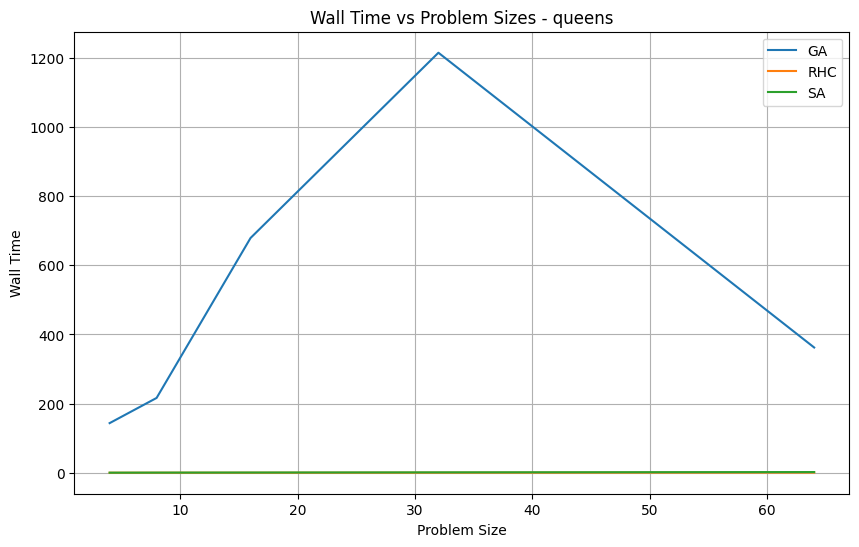

In [93]:
# Compute the average fitness across problem sizes for each algorithm and iteration
average_fitness_per_algorithm = average_queens_results.groupby(['Algorithm', 'Iteration'])['Fitness'].mean().reset_index()
# Compute the average function evaluations and time across problem sizes for each algorithm and iteration
average_fevals_per_algorithm = average_queens_results.groupby(['Algorithm', 'Iteration'])['FEvals'].mean().reset_index()
average_time_per_algorithm = average_queens_results.groupby(['Algorithm', 'Iteration'])['Time'].mean().reset_index()

# Since we want to plot Fitness vs FEvals and Fitness vs Time, we merge the average_fitness with average_fevals and average_time
average_fitness_fevals = pd.merge(average_fitness_per_algorithm, average_fevals_per_algorithm, on=['Algorithm', 'Iteration'])
average_fitness_time = pd.merge(average_fitness_per_algorithm, average_time_per_algorithm, on=['Algorithm', 'Iteration'])

# Plot 1: Fitness vs. Iterations (Epochs) - This one is correct as per your initial code
plt.figure(figsize=(10, 6))
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.title('Average Fitness vs Iterations - queens')
for algorithm in average_fitness_per_algorithm['Algorithm'].unique():
    subset = average_fitness_per_algorithm[average_fitness_per_algorithm['Algorithm'] == algorithm]
    plt.plot(subset['Iteration'], subset['Fitness'], label=f"{algorithm}")
plt.legend()
plt.grid(True)
plt.show()

# Plot 1b: Fevals vs. Iterations (Epochs) - This one is correct as per your initial code
plt.figure(figsize=(10, 6))
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.title('Average Fevals vs Iterations - queens')
for algorithm in average_fevals_per_algorithm['Algorithm'].unique():
    subset = average_fevals_per_algorithm[average_fevals_per_algorithm['Algorithm'] == algorithm]
    plt.plot(subset['Iteration'], subset['FEvals'], label=f"{algorithm}")
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Average Fitness vs. Function Evaluations
plt.figure(figsize=(10, 6))
plt.xlabel('Function Evaluations')
plt.ylabel('Fitness')
plt.title('Average Fitness vs Function Evaluations - queens')
for algorithm in average_fitness_fevals['Algorithm'].unique():
    subset = average_fitness_fevals[average_fitness_fevals['Algorithm'] == algorithm]
    plt.plot(subset['FEvals'], subset['Fitness'], label=f"{algorithm}")
plt.legend()
plt.grid(True)
plt.show()

# Plot 3: Average Fitness vs. Wall Clock Time
plt.figure(figsize=(10, 6))
plt.xlabel('Wall Clock Time (seconds)')
plt.ylabel('Fitness')
plt.title('Average Fitness vs Wall Clock Time - queens')
for algorithm in average_fitness_time['Algorithm'].unique():
    subset = average_fitness_time[average_fitness_time['Algorithm'] == algorithm]
    plt.plot(subset['Time'], subset['Fitness'], label=f"{algorithm}")
plt.legend()
plt.grid(True)
plt.show()

# Plot 4: Fitness vs. Problem Size
plt.figure(figsize=(10, 6))
problem_sizes = sorted(set(average_queens_results['Problem_Size']))
algorithms = sorted(set(average_queens_results['Algorithm']))

for algorithm in algorithms:
    fitness_values = []
    for problem_size in problem_sizes:
        subset = average_queens_results[(average_queens_results['Algorithm'] == algorithm) & (average_queens_results['Problem_Size'] == problem_size)]
        fitness_values.append(subset['Fitness'].iloc[-1])
    plt.plot(problem_sizes, fitness_values, label=algorithm)

plt.xlabel('Problem Size')
plt.ylabel('Fitness')
plt.title('Fitness vs Problem Sizes - queens')
plt.legend()
plt.grid(True)
plt.show()

# Plot 5: Wall Time vs. Problem Size
plt.figure(figsize=(10, 6))
problem_sizes = sorted(set(average_queens_results['Problem_Size']))
algorithms = sorted(set(average_queens_results['Algorithm']))

for algorithm in algorithms:
    fitness_values = []
    if algorithm != 'MIMIC':
        for problem_size in problem_sizes:
            subset = average_queens_results[(average_queens_results['Algorithm'] == algorithm) & (average_queens_results['Problem_Size'] == problem_size)]
            fitness_values.append(subset['Time'].iloc[-1])
        plt.plot(problem_sizes, fitness_values, label=algorithm)

plt.xlabel('Problem Size')
plt.ylabel('Wall Time')
plt.title('Wall Time vs Problem Sizes - queens')
plt.legend()
plt.grid(True)
plt.show()